# Case 1. Найти нефть 

## 1. Импорт необходимых библиотек

In [182]:
# Общие
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

# Рисование 
from matplotlib import pyplot as plt
import seaborn as sns

# ML 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# Метрики и валидация 
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

## 2. Загрузка данных и их оценка

### 2.1. Тренировочный набор 

In [113]:
%time
train_df = pd.read_excel('train.xlsx')

Wall time: 0 ns


In [165]:
train_df.head()

,well id,"depth, m",bk,GZ1,GZ2,GZ3,GZ4,GZ5,GZ7,DGK,NKTD,NKTM,NKTR,ALPS,lith,goal
0,12.0,3042.4630,0.455779,0.774000,0.774000,0.332846,0.476545,0.774000,0.244898,0.123651,0.774000,0.799167,0.174639,0.727789,NK,0.0
1,33.0,2412.8305,0.000000,0.157153,0.755472,0.453216,0.715147,0.000000,0.523432,0.388729,0.519233,0.799167,0.563573,0.111216,ARGILLIT,0.0
2,33.0,2522.5575,0.000000,0.172235,0.941742,0.525711,0.668600,0.000000,0.588924,0.515214,0.527139,0.799167,0.551152,0.172359,ARGILLIT,0.0
3,49.0,2396.3625,0.381248,0.246838,0.116913,0.732654,0.151299,0.165219,0.656955,0.445917,0.575175,0.799167,0.429433,0.253563,ARGILLIT,0.0
4,49.0,2399.0475,0.356867,0.226241,0.155473,0.613300,0.173949,0.297194,0.773218,0.392743,0.575725,0.799167,0.447169,0.959633,ARGILLIT,0.0


In [166]:
train_df.describe()

,well id,"depth, m",bk,GZ1,GZ2,GZ3,GZ4,GZ5,GZ7,DGK,NKTD,NKTM,NKTR,ALPS,goal
count,465096.000000,465096.000000,465096.000000,465096.000000,465096.000000,465096.000000,465096.000000,465096.000000,465096.000000,465096.000000,465096.000000,465096.000000,465096.000000,465096.000000,465096.000000
mean,156.624994,2340.714509,0.301883,0.244036,0.338601,0.446509,0.161452,0.097156,0.180136,0.141877,0.258189,0.259655,0.128890,0.380011,0.150227
std,86.518091,402.562961,0.186004,0.174513,0.295100,0.274443,0.287997,0.165398,0.292954,0.210669,0.205655,0.272957,0.208668,0.253311,0.357294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,2173.776000,0.196348,0.151864,0.126251,0.236196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.168399,0.000000
50%,166.000000,2391.977000,0.317619,0.231755,0.182283,0.453581,0.000000,0.000000,0.000000,0.000000,0.316475,0.000000,0.000000,0.318824,0.000000
75%,232.000000,2581.180000,0.388959,0.287222,0.567430,0.668230,0.156749,0.183785,0.351324,0.357816,0.393153,0.523462,0.358733,0.559920,0.000000
max,287.000000,3155.591000,0.999848,0.999973,0.999756,0.999994,0.999960,0.998834,0.999648,0.999514,0.799599,0.799167,0.998569,0.999996,1.000000


Посмотрим соотношения классов и узнаем насколько классы сбалансированы

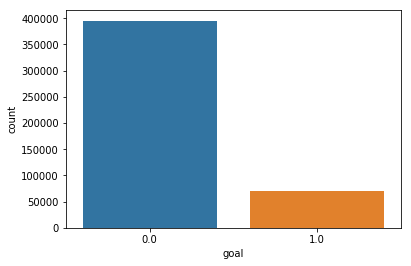

In [167]:
sns.countplot(train_df['goal']);

In [168]:
# Функция принимате на вход pd.DataFrame 
# Возвращает таблицу, в которой указано сколько пустых значений по каждой колонке
def na_count_by_col(df, percentage=False):
    columns = df.columns
    na_count = []
    na_count_perc = []
    for col in columns:
        na_in_col = len(df[col]) - df[col].count()
        na_count.append( na_in_col )
        na_count_perc.append( na_in_col / len(df[col]))
    if not percentage:
        d = {'column_name' : columns, 'na_count' : na_count}
    else:
        d = {'column_name' : columns, 'na_count' : na_count_perc}
    return pd.DataFrame(data=d)

In [169]:
na_count_by_col(train_df)

,column_name,na_count
0,well id,0
1,"depth, m",0
2,bk,0
3,GZ1,0
4,GZ2,0
5,GZ3,0
6,GZ4,0
7,GZ5,0
8,GZ7,0
9,DGK,0


In [170]:
train_df[train_df['well id'].isnull()].head()

,well id,"depth, m",bk,GZ1,GZ2,GZ3,GZ4,GZ5,GZ7,DGK,NKTD,NKTM,NKTR,ALPS,lith,goal


Видим, что там, где поле *'well id'* принимает значение 'NaN' все остальные поля равны NaN => эти строки удаляем  

In [52]:
train_df.drop(train_df[train_df['well id'].isnull()].index, inplace=True)

Проверим еще раз колонки на пустые значения

In [171]:
na_count_by_col(train_df).sort_values(by=['na_count'], ascending=False)

,column_name,na_count
0,well id,0
1,"depth, m",0
2,bk,0
3,GZ1,0
4,GZ2,0
5,GZ3,0
6,GZ4,0
7,GZ5,0
8,GZ7,0
9,DGK,0


<span style="color:red">__КОСТЫЛЬ__</span>

In [172]:
train_df = train_df.fillna(0)

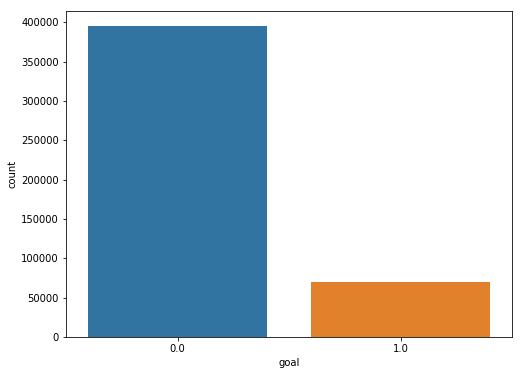

In [173]:
plt.figure(figsize=(8,6))
sns.countplot(train_df['goal'])

### 2.2. Тестовый набор 

In [174]:
test_df = pd.read_excel('test.xlsx')

In [175]:
test_df.head()

,id,well id,"depth, m",bk,GZ1,GZ2,GZ3,GZ4,GZ5,GZ7,DGK,NKTD,NKTM,NKTR,ALPS
0,1,47,2465.5460,0.665198,0.259688,0.865866,0.526683,0.116218,0.464870,0.124486,0.196296,0.483192,0.643774,0.376472,0.261831
1,2,47,2465.6355,0.115153,0.258287,0.161988,0.583114,0.122256,0.477795,0.118895,0.146578,0.491132,0.655735,0.359872,0.236470
2,3,47,2465.7250,0.155254,0.318849,0.125817,0.639544,0.128194,0.497212,0.111693,0.968615,0.499726,0.667695,0.343272,0.266756
3,4,47,2465.8145,0.125315,0.474215,0.149127,0.638636,0.128239,0.478265,0.987464,0.546126,0.492469,0.659642,0.341159,0.332568
4,5,47,2465.9040,0.953756,0.638341,0.172437,0.637663,0.113455,0.465892,0.858188,0.123651,0.485865,0.651513,0.339456,0.398383


## 3. Предсказанию 'lith'

### 3.1. Подготовка данных

In [185]:
le = LabelEncoder()

In [192]:
train_df['lith'] = train_df['lith'].astype('str')

In [193]:
train_df['lith']

0                NK
1          ARGILLIT
2          ARGILLIT
3          ARGILLIT
4          ARGILLIT
5          ARGILLIT
6          ARGILLIT
7          ARGILLIT
8          ARGILLIT
9          ARGILLIT
10            DENSE
11        ALEVROLIT
12         ARGILLIT
13         ARGILLIT
14         ARGILLIT
15         ARGILLIT
16         ARGILLIT
17         ARGILLIT
18         ARGILLIT
19         ARGILLIT
20         ARGILLIT
21            DENSE
22            DENSE
23             SAND
24            DENSE
25        ALEVROLIT
26        ALEVROLIT
27             SAND
28         ARGILLIT
29             SAND
            ...    
465066     ARGILLIT
465067        DENSE
465068        DENSE
465069        DENSE
465070        DENSE
465071        DENSE
465072        DENSE
465073        DENSE
465074     ARGILLIT
465075     ARGILLIT
465076     ARGILLIT
465077     ARGILLIT
465078     ARGILLIT
465079     ARGILLIT
465080     ARGILLIT
465081     ARGILLIT
465082     ARGILLIT
465083     ARGILLIT
465084     ARGILLIT


In [194]:
X1 = train_df.drop(['lith', 'goal'], axis=1)
y1 = train_df['lith']
X1.shape, y1.shape

((465096, 14), (465096,))

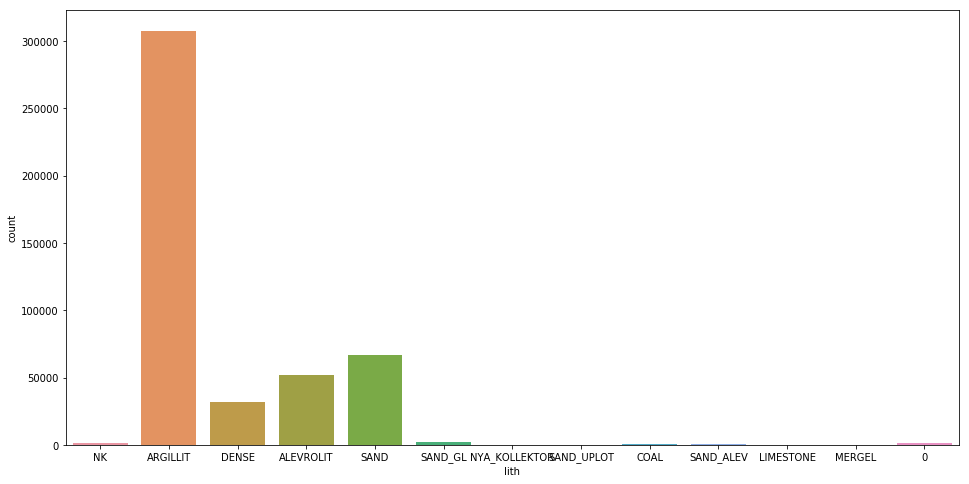

In [178]:
plt.figure(figsize=(16,8))
sns.countplot(y1);

In [195]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42)

### 3.2. RandomForest  

#### 3.2.1. Первый лес

In [196]:
rfc_lith = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True, n_estimators=20)

In [197]:
%%time
rfc_lith.fit(X_train1, y_train1)

Wall time: 13.9 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [198]:
y_lith_pred = rfc_lith.predict(X_test1)

In [204]:
y_lith_pred = y_lith_pred.astype('str')
y_lith_pred

array(['SAND', 'ARGILLIT', 'ARGILLIT', ..., 'ARGILLIT', 'SAND',
       'ARGILLIT'], dtype='<U13')

In [205]:
def calc_scores(y_test, y_pred):
    print('f1:', f1_score(y_test, y_pred, average='macro'))
    print('accuracy: ', accuracy_score(y_test, y_pred))
    print('precision: ', precision_score(y_test, y_pred, average='macro'))
    print('recall: ', recall_score(y_test, y_pred, average='macro'))

In [207]:
calc_scores(y_test1, y_lith_pred)

f1: 0.6440961065520345
accuracy:  0.8733739939367443
precision:  0.7329535720124286
recall:  0.5928873628985161


#### 3.2.2. Оптимизация параметров случайного леса

<span style="color:red">__Доделать оптимизацию__</span>

In [ ]:
# n_estimators — число деревьев в "лесу"
# criterion — критерий для разбиения выборки в вершине
# max_features — число признаков, по которым ищется разбиение
# min_samples_leaf — минимальное число объектов в листе
# max_depth — максимальная глубина дерева
rfc_params = {
    'n_estimators': [20], 
    'max_features': np.arange(3, X_train.shape[1]+1)
#     'min_samples_leaf': np.arange(3,26,2),
#     'max_depth': np.arange(3,26,2)
    }

In [ ]:
rfc_grid = GridSearchCV(rfc, rfc_params, cv=5, n_jobs=-1, verbose=1)

In [ ]:
%%time
# rfc_grid.fit(X_train, y_train)

In [ ]:
# rfc_grid.best_score_, rfc_grid.best_params_

##  4. Предсказание 'goal'

### 4.0. Подготовк аданных для линейных моделей 

In [208]:
X = train_df.drop(['lith', 'goal'], axis=1)
y = train_df['goal']
X.shape

(465096, 14)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

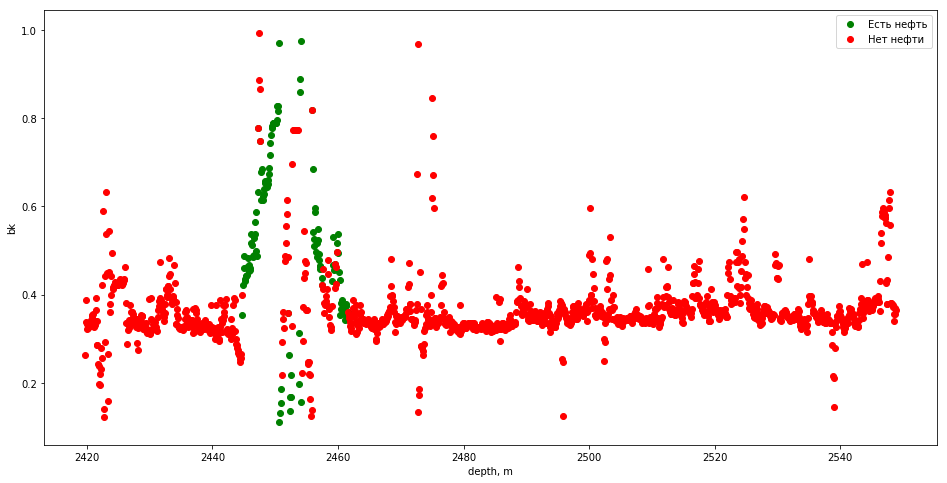

In [91]:
plt.figure(figsize=(16,8))
plt.scatter(train_df[ (train_df['goal'] == 1) & (train_df['well id'] == 2)]['depth, m'], train_df[(train_df['goal'] == 1) & (train_df['well id'] == 2)]['bk'], c = 'green', label = 'Есть нефть')
plt.scatter(train_df[ (train_df['goal'] == 0) & (train_df['well id'] == 2)]['depth, m'], train_df[(train_df['goal'] == 0) & (train_df['well id'] == 2)]['bk'], c = 'red', label = 'Нет нефти')
plt.xlabel('depth, m')
plt.ylabel('bk')
plt.legend();

In [210]:
scaler = StandardScaler().fit(X_train)

In [211]:
X_train_norm = scaler.transform(X_train)

In [212]:
X_test_norm = scaler.transform(X_test)

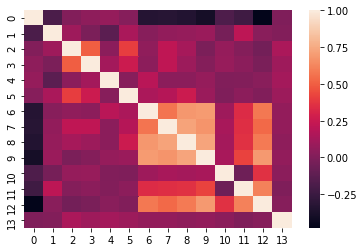

In [213]:
sns.heatmap(pd.DataFrame(data=X_train_norm).corr())

### 4.1. Логистическая регрессия 

In [71]:
logit = LogisticRegression(n_jobs=-1, random_state=17)

In [72]:
%time
logit.fit(X_train_norm, y_train)

Wall time: 0 ns


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=17,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [109]:
y_goal_pred = logit.predict(X_test_norm)

In [111]:
y_goal_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [74]:
f1_score(y_test, y_pred)

0.21978522369369716

In [75]:
logit.coef_ 

array([[-0.11068534, -0.47695494,  0.6758122 ,  0.19356171, -0.48504317,
        -0.34206254, -0.07955153,  0.0442984 , -0.09234446, -0.3057098 ,
         0.01602468,  0.08296919,  0.27425103,  0.44215543]])

### 4.2. RandomForest 

In [76]:
rfc_goal = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True, n_estimators=20)

In [77]:
rfc_goal.fit(X_train_norm, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [78]:
y_pred = rfc_goal.predict(X_test_norm)

In [79]:
calc_scores(y_pred, y_test)

f1: 0.893896190177688
accuracy:  0.9480491485233886
precision:  0.8764965993462295
recall:  0.9140461609683486


### 4.3. SVM 

In [ ]:
svc = SVC(kernel='linear', c=1, gamma=1)

### 4.4. LightGBM

In [225]:
lgbmc = lgb.LGBMClassifier()

In [226]:
lgbmc.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [227]:
y_pred = lgbmc.predict(X_test)

In [228]:
calc_scores(y_test, y_pred)

f1: 0.8322025178568744
accuracy:  0.9200882970565258
precision:  0.8608691306006455
recall:  0.8096525080818545


## 5. Отбор признаков 

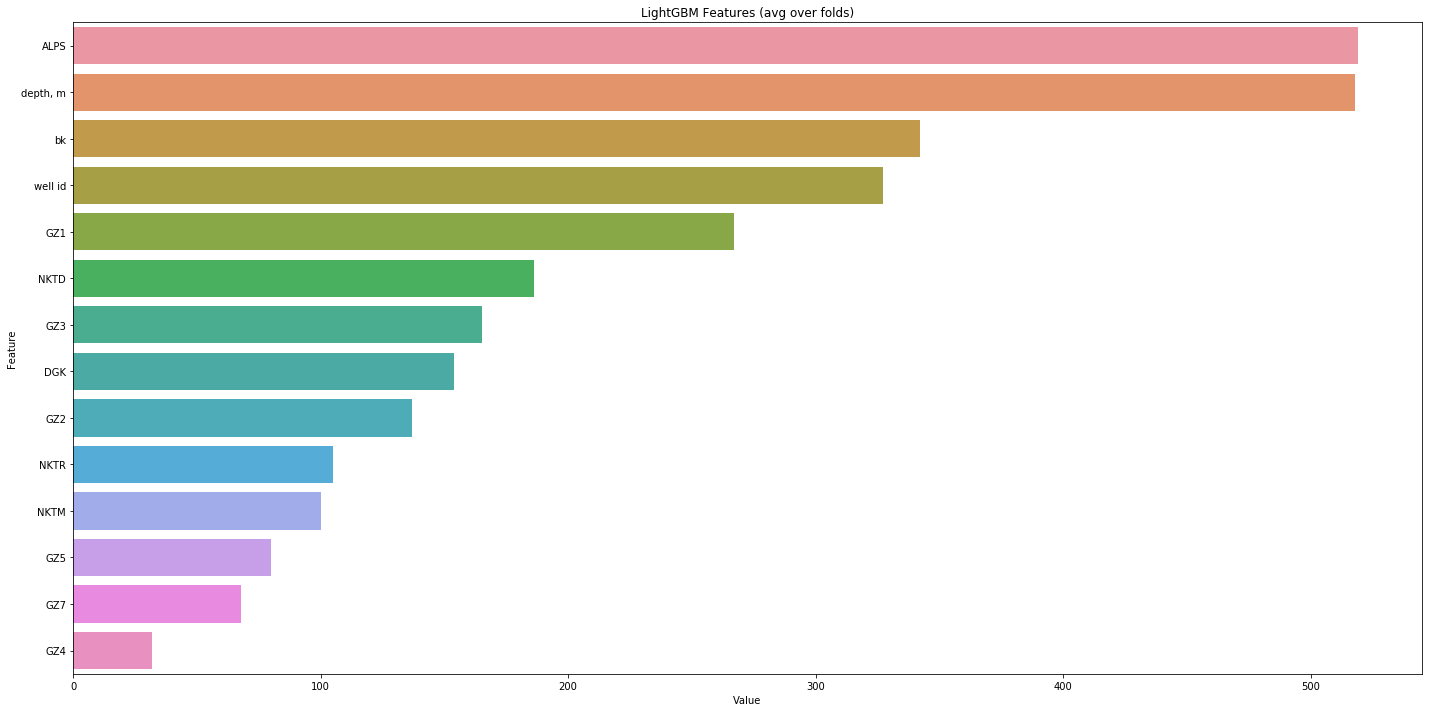

In [248]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbmc.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [257]:
# ALPS, bk, GZ1 (NKTD)
df3 = train_df[['ALPS', 'bk', 'GZ1', 'goal']]

In [263]:
df3 = df3.fillna(0)

In [264]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465096 entries, 0 to 465095
Data columns (total 4 columns):
ALPS    465096 non-null float64
bk      465096 non-null float64
GZ1     465096 non-null float64
goal    465096 non-null float64
dtypes: float64(4)
memory usage: 14.2 MB


In [267]:
X3 = df3.drop('goal', axis=1)
y3 = df3['goal']

In [268]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=42)

In [269]:
lgbmc3 = lgb.LGBMClassifier()

In [272]:
lgbmc3.fit(X_train3, y_train3)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [274]:
y3_pred = lgbmc3.predict(X_test3)

In [276]:
calc_scores(y_test3, y3_pred)

f1: 0.7536051887798667
accuracy:  0.8925528026431782
precision:  0.8156142431664591
recall:  0.7187002101589888


In [278]:
df4 = train_df[['ALPS', 'bk', 'GZ1', 'NKTD', 'goal']]

In [280]:
df4 = df4.fillna(0)

In [282]:
X4 = df4.drop('goal', axis=1)
y4 = df4['goal']

In [283]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state=42)

In [285]:
lgbmc4 = lgb.LGBMClassifier()

In [287]:
lgbmc4.fit(X_train4, y_train4)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [290]:
y4_pred = lgbmc4.predict(X_test4)
calc_scores(y_test4, y4_pred)

f1: 0.7879017191539726
accuracy:  0.9019271979301794
precision:  0.8257914245646719
recall:  0.7612084915123258


## 6. Формирование итогового файла 

In [219]:
X_val = test_df.drop('id', axis=1).fillna(0)
X_val.head()

,well id,"depth, m",bk,GZ1,GZ2,GZ3,GZ4,GZ5,GZ7,DGK,NKTD,NKTM,NKTR,ALPS
0,47,2465.5460,0.665198,0.259688,0.865866,0.526683,0.116218,0.464870,0.124486,0.196296,0.483192,0.643774,0.376472,0.261831
1,47,2465.6355,0.115153,0.258287,0.161988,0.583114,0.122256,0.477795,0.118895,0.146578,0.491132,0.655735,0.359872,0.236470
2,47,2465.7250,0.155254,0.318849,0.125817,0.639544,0.128194,0.497212,0.111693,0.968615,0.499726,0.667695,0.343272,0.266756
3,47,2465.8145,0.125315,0.474215,0.149127,0.638636,0.128239,0.478265,0.987464,0.546126,0.492469,0.659642,0.341159,0.332568
4,47,2465.9040,0.953756,0.638341,0.172437,0.637663,0.113455,0.465892,0.858188,0.123651,0.485865,0.651513,0.339456,0.398383


In [223]:
lith = rfc_lith.predict(X_val)
lith

array(['DENSE', 'ARGILLIT', 'DENSE', ..., 'ARGILLIT', 'ARGILLIT',
       'ARGILLIT'], dtype=object)

In [233]:
goal = lgbmc.predict(X_val)

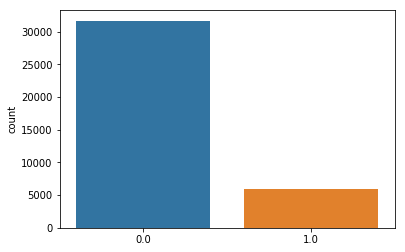

In [235]:
sns.countplot(goal)

In [237]:
len(X_val['well id']), len(goal), len(lith)

(37604, 37604, 37604)

In [242]:
test_df['lith'] = lith
test_df['goal'] = goal

In [244]:
test_df.head()

,id,well id,"depth, m",bk,GZ1,GZ2,GZ3,GZ4,GZ5,GZ7,DGK,NKTD,NKTM,NKTR,ALPS,lith,goal
0,1,47,2465.5460,0.665198,0.259688,0.865866,0.526683,0.116218,0.464870,0.124486,0.196296,0.483192,0.643774,0.376472,0.261831,DENSE,0.0
1,2,47,2465.6355,0.115153,0.258287,0.161988,0.583114,0.122256,0.477795,0.118895,0.146578,0.491132,0.655735,0.359872,0.236470,ARGILLIT,0.0
2,3,47,2465.7250,0.155254,0.318849,0.125817,0.639544,0.128194,0.497212,0.111693,0.968615,0.499726,0.667695,0.343272,0.266756,DENSE,0.0
3,4,47,2465.8145,0.125315,0.474215,0.149127,0.638636,0.128239,0.478265,0.987464,0.546126,0.492469,0.659642,0.341159,0.332568,SAND,0.0
4,5,47,2465.9040,0.953756,0.638341,0.172437,0.637663,0.113455,0.465892,0.858188,0.123651,0.485865,0.651513,0.339456,0.398383,DENSE,0.0


In [246]:
test_df.to_excel('test_predicted.xlsx')